<a href="https://colab.research.google.com/github/kt3472/oss_ai_class/blob/master/practice_DCGAN_1207.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import torch.optim as optim

In [0]:
device = torch.device("cuda:0")
criterion = nn.BCELoss()
epochs = 5
batch_size = 100
nz = 100
ngf = 64
ndf = 64

In [0]:
def show_generated_data(real_data, fake_data):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_data[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

    # Plot the fake images from the last epoch
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(vutils.make_grid(fake_data.detach()[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))
    plt.show()

In [0]:
dataloader = torch.utils.data.DataLoader(
    dset.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))
                   ])),
    batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:06, 1609089.62it/s]                            


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 129643.73it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


1654784it [00:00, 2141181.34it/s]                            
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


8192it [00:00, 49199.91it/s]            


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [0]:

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
class Net_generator(nn.Module):
    def __init__(self, nz, ngf):
        super(Net_generator, self).__init__()
        self.nz = nz
        self.ngf = ngf
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.nz, out_channels=self.ngf*4, kernel_size=5,stride=1,padding=1),
            nn.BatchNorm2d(self.ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 5, 1, 1),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 5, 2, 0),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.ngf, 1, 4, 2, 0),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.generator(input)
        return output


In [0]:
class Net_Discriminator(nn.Module):
    def __init__(self, ndf):
        super(Net_Discriminator, self).__init__()
        self.ndf = ndf

        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.ndf, kernel_size=5, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(self.ndf, self.ndf*2, 4, 2, 1),
            nn.BatchNorm2d(self.ndf*2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(self.ndf*2, self.ndf*4, 4, 2, 1),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(self.ndf*4,1,3,1,0),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.discriminator(input)
        return output


In [0]:
net_generator = Net_generator(nz, ngf).to(device)
net_generator.apply(weights_init)

net_discriminator = Net_Discriminator(ndf).to(device)
net_discriminator.apply(weights_init)

Net_Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1))
    (9): Sigmoid()
  )
)

In [0]:
label = torch.FloatTensor(batch_size).to(device)
real_label = 1
fake_label = 0

In [0]:
optimizerD = optim.Adam(net_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(net_generator.parameters(), lr=0.001, betas=(0.5, 0.999))
G_losses = []
D_losses = []

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[0/5][0/600] Loss_D: 1.9554 Loss_G: 2.1699 


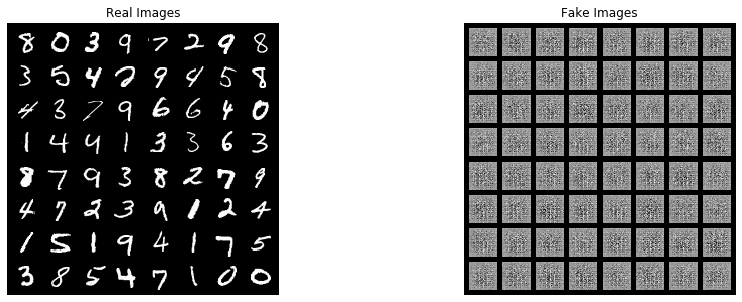

[0/5][100/600] Loss_D: 0.6837 Loss_G: 4.9132 


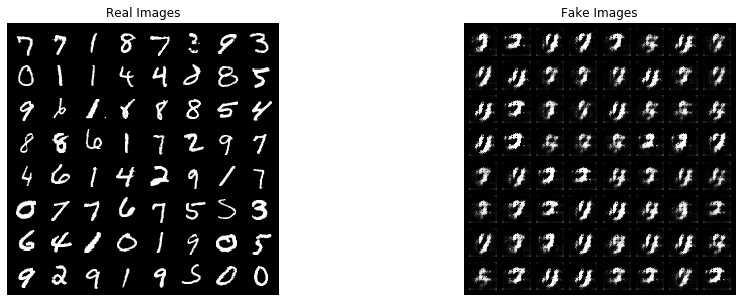

[0/5][200/600] Loss_D: 0.8751 Loss_G: 2.8064 


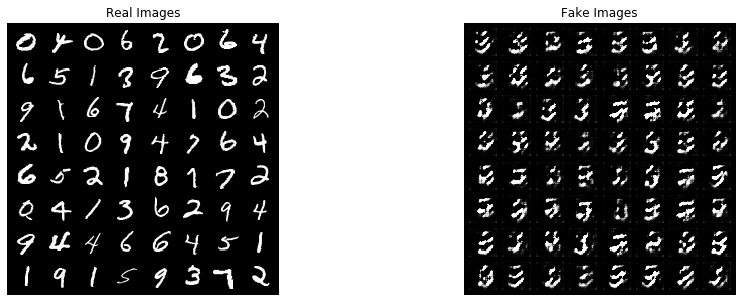

[0/5][300/600] Loss_D: 1.2260 Loss_G: 1.9186 


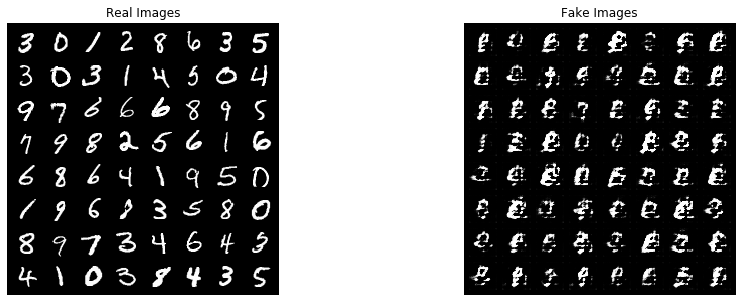

[0/5][400/600] Loss_D: 0.7972 Loss_G: 2.3058 


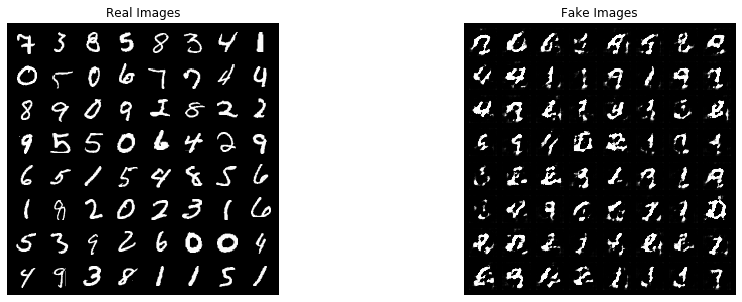

[0/5][500/600] Loss_D: 1.0423 Loss_G: 2.1685 


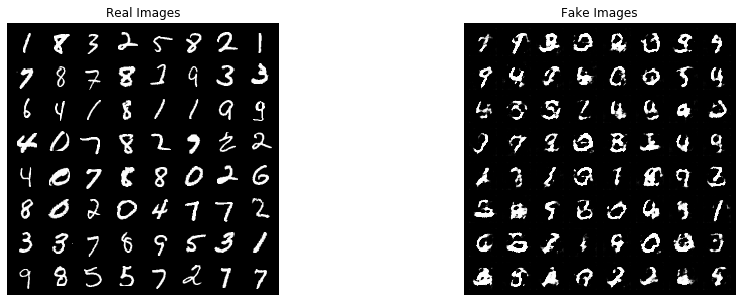

[1/5][0/600] Loss_D: 1.1923 Loss_G: 0.6208 


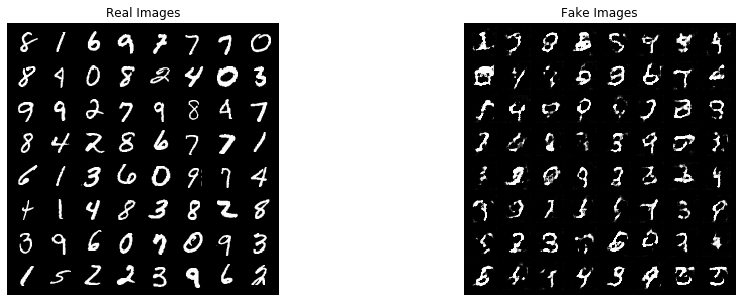

[1/5][100/600] Loss_D: 1.1942 Loss_G: 0.8603 


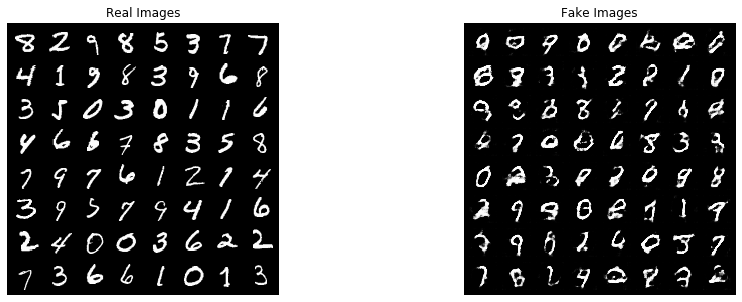

[1/5][200/600] Loss_D: 1.0975 Loss_G: 0.9227 


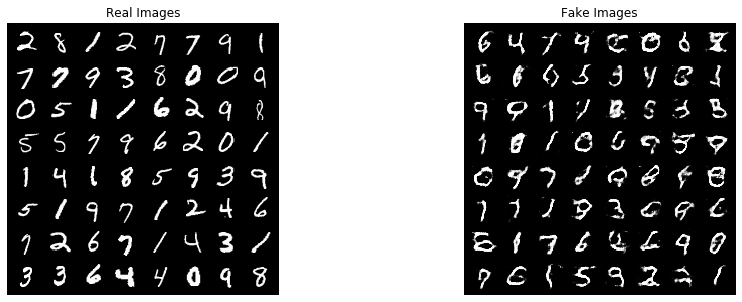

[1/5][300/600] Loss_D: 1.2337 Loss_G: 0.9067 


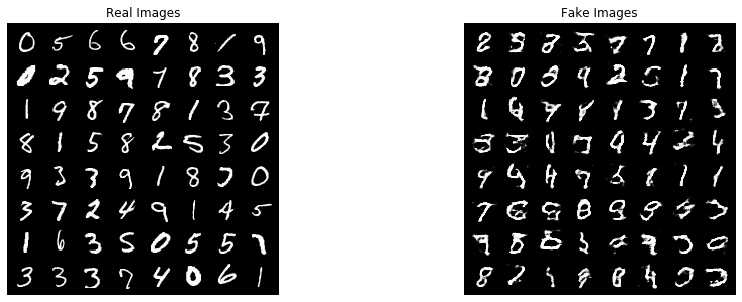

[1/5][400/600] Loss_D: 1.0762 Loss_G: 1.3093 


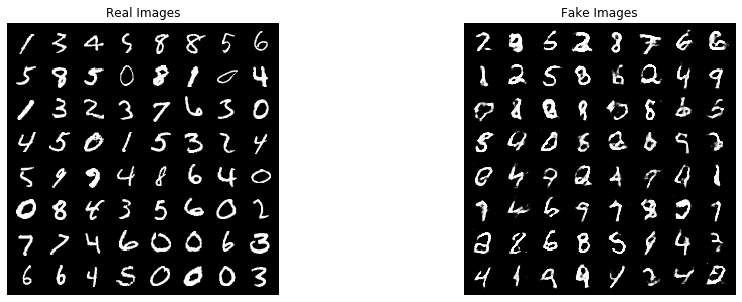

[1/5][500/600] Loss_D: 1.1245 Loss_G: 0.9558 


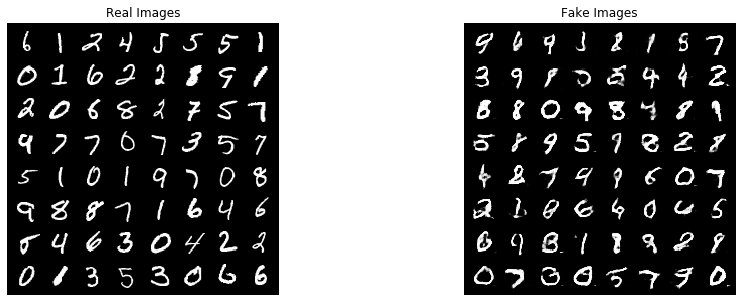

[2/5][0/600] Loss_D: 1.1370 Loss_G: 1.3101 


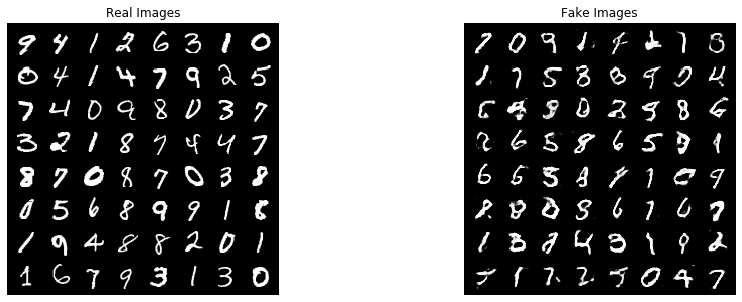

[2/5][100/600] Loss_D: 1.2352 Loss_G: 0.8195 


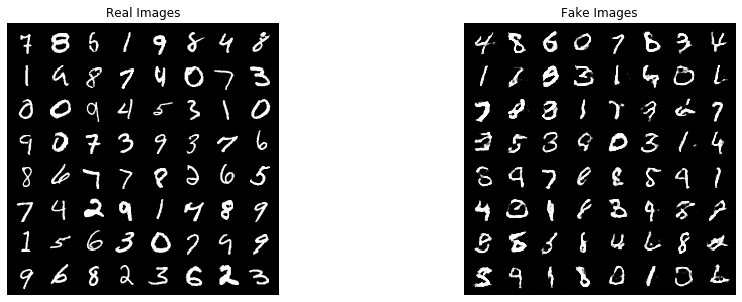

[2/5][200/600] Loss_D: 1.0819 Loss_G: 1.2195 


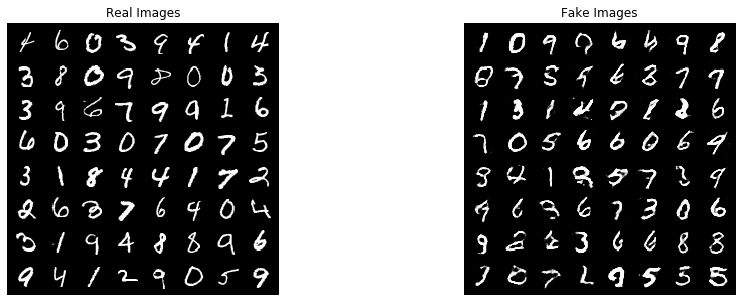

[2/5][300/600] Loss_D: 1.4111 Loss_G: 0.3642 


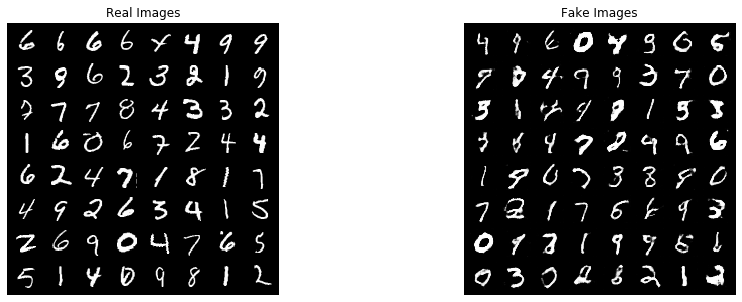

[2/5][400/600] Loss_D: 1.2408 Loss_G: 1.7889 


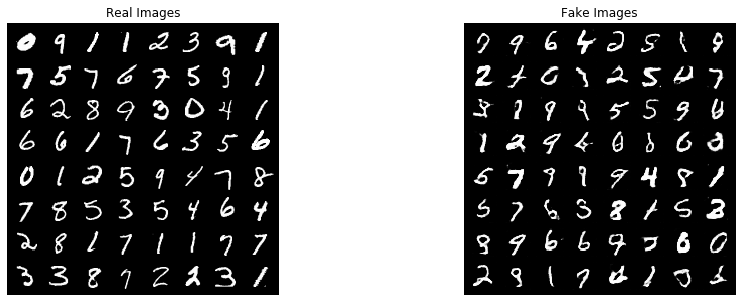

[2/5][500/600] Loss_D: 1.0620 Loss_G: 1.1047 


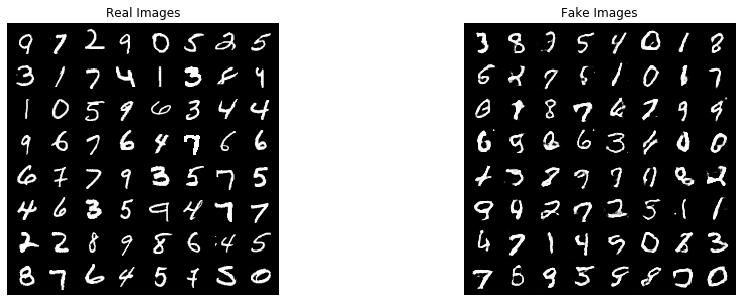

[3/5][0/600] Loss_D: 1.5066 Loss_G: 0.3688 


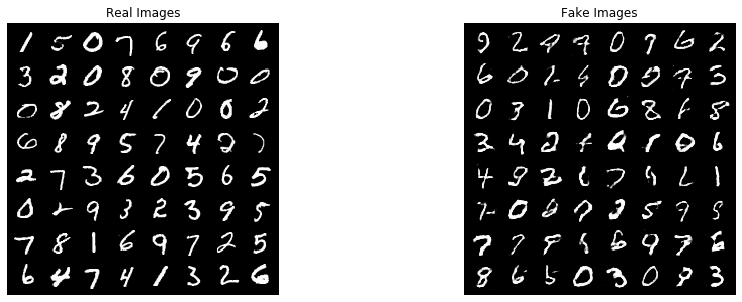

[3/5][100/600] Loss_D: 1.1735 Loss_G: 0.4923 


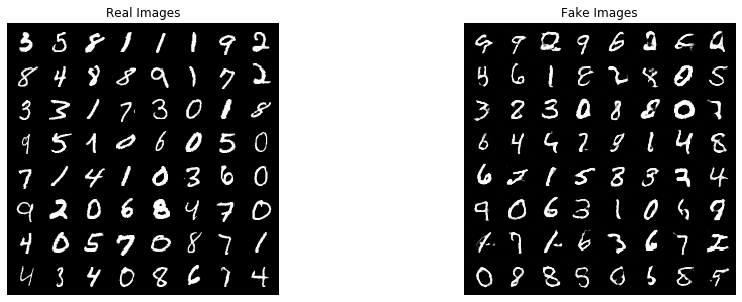

[3/5][200/600] Loss_D: 1.0426 Loss_G: 1.1046 


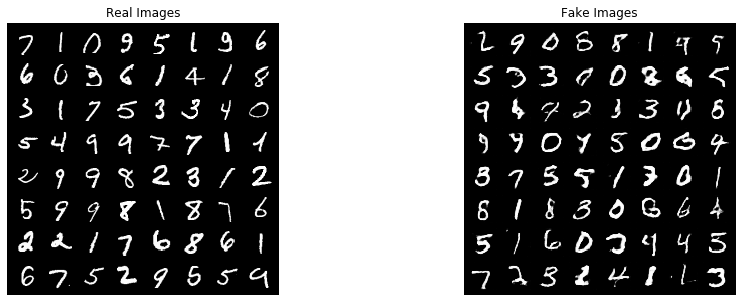

[3/5][300/600] Loss_D: 1.2250 Loss_G: 1.3709 


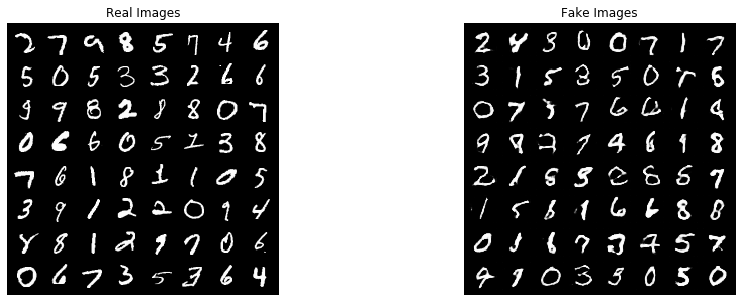

[3/5][400/600] Loss_D: 1.0174 Loss_G: 1.1713 


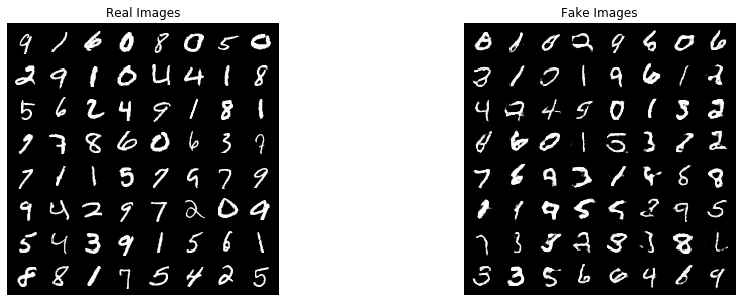

[3/5][500/600] Loss_D: 1.2193 Loss_G: 0.9790 


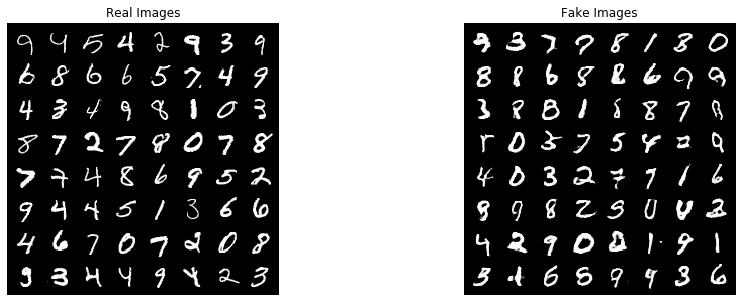

[4/5][0/600] Loss_D: 1.1714 Loss_G: 1.0059 


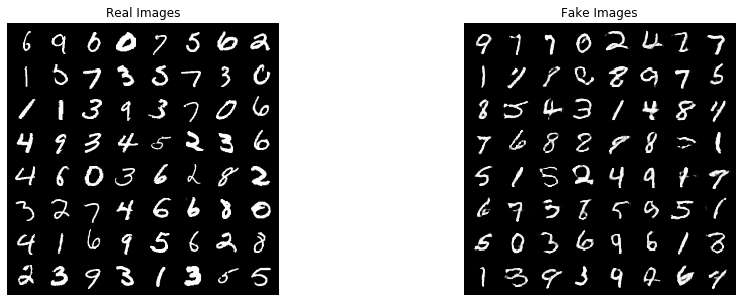

[4/5][100/600] Loss_D: 1.1006 Loss_G: 1.5879 


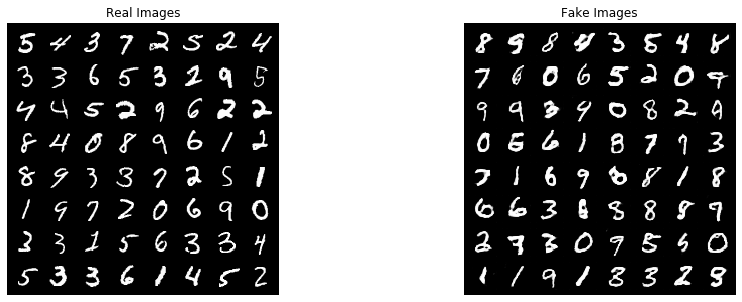

[4/5][200/600] Loss_D: 1.1170 Loss_G: 1.1456 


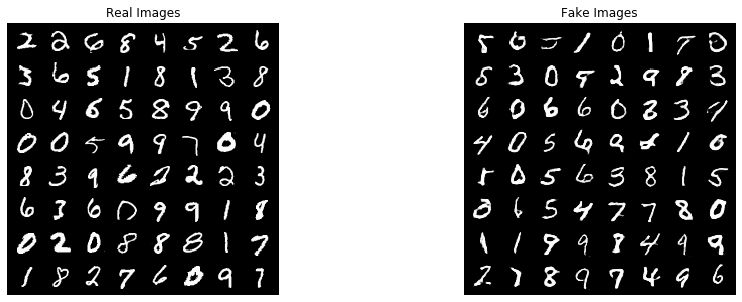

[4/5][300/600] Loss_D: 1.3135 Loss_G: 0.6296 


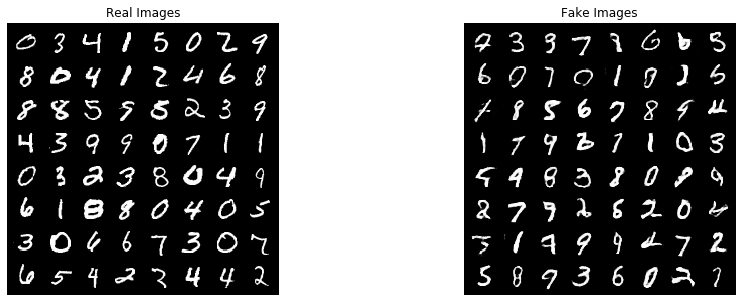

[4/5][400/600] Loss_D: 0.9383 Loss_G: 1.6932 


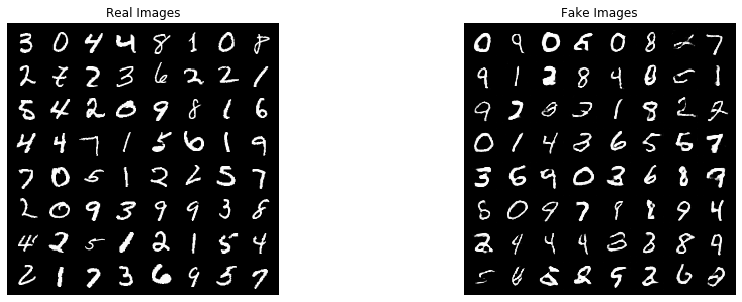

[4/5][500/600] Loss_D: 1.3260 Loss_G: 1.6049 


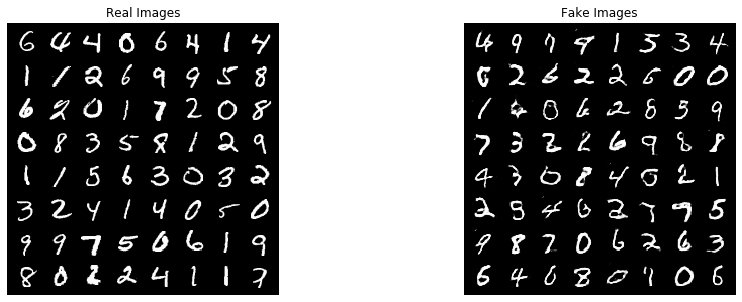

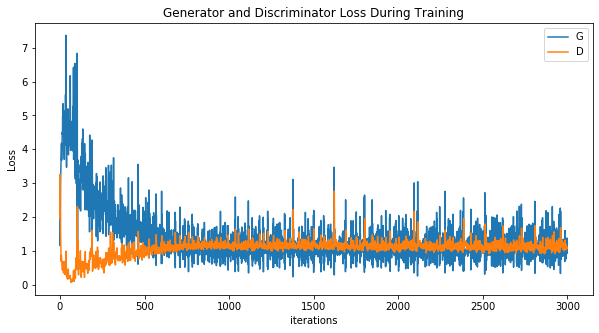

In [0]:

for epoch in range(epochs):
    for i, (real_data, _) in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        real_data = real_data.to(device)
        label.data.fill_(real_label)
        real_output = net_discriminator(real_data)
        errD_real = criterion(real_output, label)
        net_discriminator.zero_grad()
        errD_real.backward()

        # train with fake
        noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1).to(device)
        fake_data = net_generator(noise)
        label.data.fill_(fake_label)

        fake_output = net_discriminator(fake_data.detach())
        errD_fake = criterion(fake_output, label)
        errD_fake.backward()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        net_generator.zero_grad()
        label.data.fill_(real_label)  # fake labels are real for generator cost
        fake_output = net_discriminator(fake_data)
        errG = criterion(fake_output, label)
        errG.backward()
        optimizerG.step()

      
        G_losses.append(errG.item())
        D_losses.append(errD_real+errD_fake.item())
        
        if i %100 == 0 :
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f '
                  % (epoch, epochs, i, len(dataloader),
                     (errD_real + errD_fake).item(), errG.item()))
            show_generated_data(real_data,fake_data)


plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()